# Tutorial: Scorecard with binary target
source : https://gnpalencia.org/optbinning/tutorials/tutorial_scorecard_binary_target.html

In this tutorial, we use the dataset from the FICO Explainable Machine Learning Challenge: https://community.fico.com/s/explainable-machine-learning-challenge. The goal is to develop a scorecard using the logistic regression as an estimator.

In [ ]:
!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score,classification_report,confusion_matrix,accuracy_score

In [2]:
from sklearn.linear_model import LogisticRegression
from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

(CVXPY) Sep 20 08:33:00 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 20 08:33:00 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


Download the dataset from https://github.com/benoitparis/explainable-challenge


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/benoitparis/explainable-challenge/master/heloc_dataset_v1.csv")

In [4]:
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [5]:
variable_names = list(df.columns[1:])
X = df[variable_names]

Transform the categorical dichotomic target variable into numerical.

In [6]:
target = "RiskPerformance"
y = df[target].values
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

We specify a selection criteria in terms of the Information Value (IV) predictiveness and minimum quality score to remove low-quality variables. Then, we instantiate a `BinningProcess` object class with variable names, special codes and selection criteria.

In [7]:
selection_criteria = {
    "iv": {"min": 0.1, "max": 1}
}

In [8]:
binning_process = BinningProcess(variable_names,
                                 selection_criteria=selection_criteria)
binning_process.fit(X,y)

BinningProcess(selection_criteria={'iv': {'max': 1, 'min': 0.1}},
               variable_names=['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
                               'MSinceMostRecentTradeOpen', 'AverageMInFile',
                               'NumSatisfactoryTrades',
                               'NumTrades60Ever2DerogPubRec',
                               'NumTrades90Ever2DerogPubRec',
                               'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
                               'MaxDelq2PublicRecLast12M', 'MaxDelqEver',
                               'NumTotalTrades', 'NumTradesOpeninLast12M',
                               'PercentInstallTrades',
                               'MSinceMostRecentInqexcl7days', 'NumInqLast6M',
                               'NumInqLast6Mexcl7days',
                               'NetFractionRevolvingBurden',
                               'NetFractionInstallBurden',
                               'NumRevolvingTradesWBalance',
                               'NumInstallTradesWBalance',
                               'NumBank2NatlTradesWHighUtilization',
                               'PercentTradesWBalance'])

In [9]:
binning_process.summary().sort_values(['iv'],ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,ExternalRiskEstimate,numerical,OPTIMAL,True,12,0.881917,0.103014,0.496434,0.039178
17,NetFractionRevolvingBurden,numerical,OPTIMAL,True,12,0.570905,0.067645,0.41118,0.391129
22,PercentTradesWBalance,numerical,OPTIMAL,True,13,0.340026,0.041132,0.321526,0.067079
21,NumBank2NatlTradesWHighUtilization,numerical,OPTIMAL,True,6,0.326566,0.039983,0.304532,0.700104
9,MaxDelq2PublicRecLast12M,numerical,OPTIMAL,True,5,0.303603,0.037062,0.289707,0.543903
7,PercentTradesNeverDelq,numerical,OPTIMAL,True,6,0.298894,0.036675,0.288852,0.655093
3,AverageMInFile,numerical,OPTIMAL,True,10,0.257898,0.031641,0.282183,0.12945
14,MSinceMostRecentInqexcl7days,numerical,OPTIMAL,True,6,0.232395,0.028587,0.238348,0.026092
8,MSinceMostRecentDelq,numerical,OPTIMAL,True,3,0.204709,0.025352,0.23016,0.526367
10,MaxDelqEver,numerical,OPTIMAL,True,3,0.204393,0.025306,0.234341,0.603114


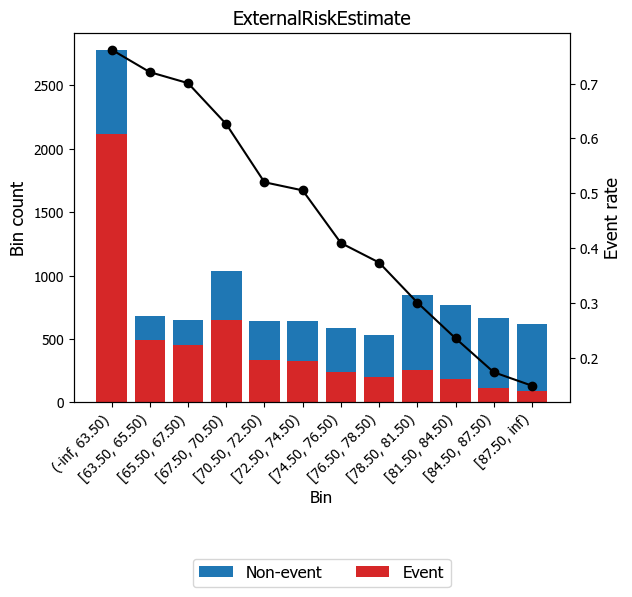

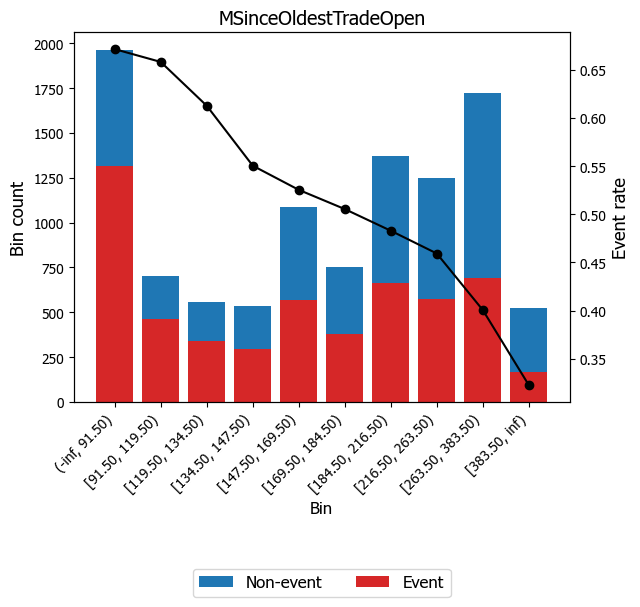

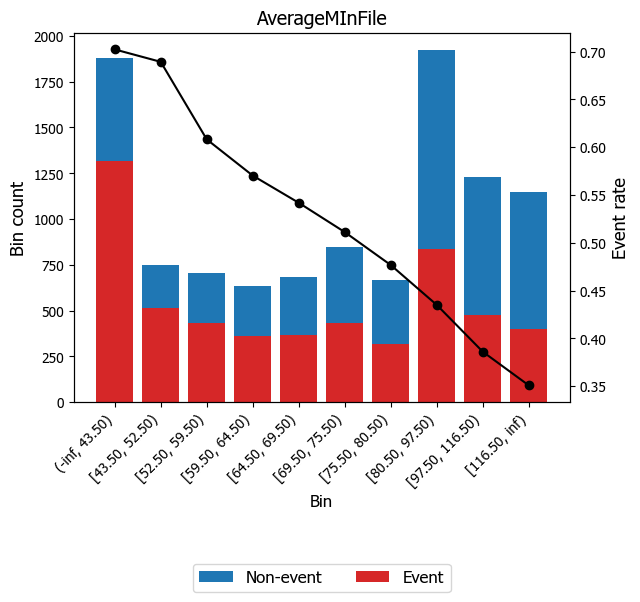

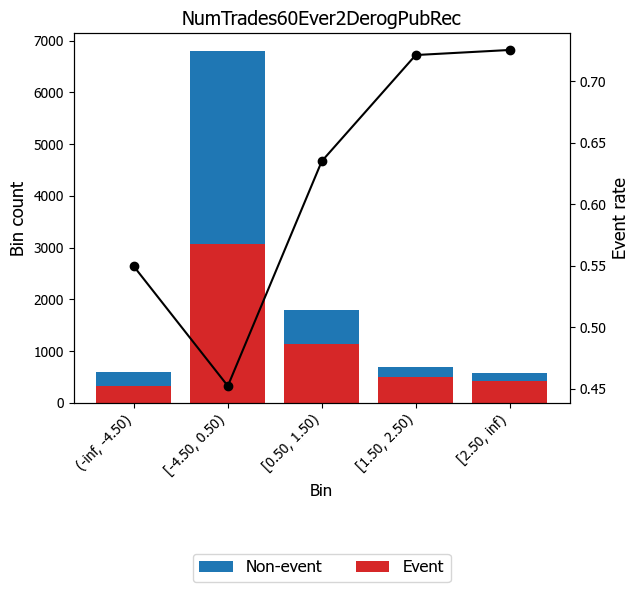

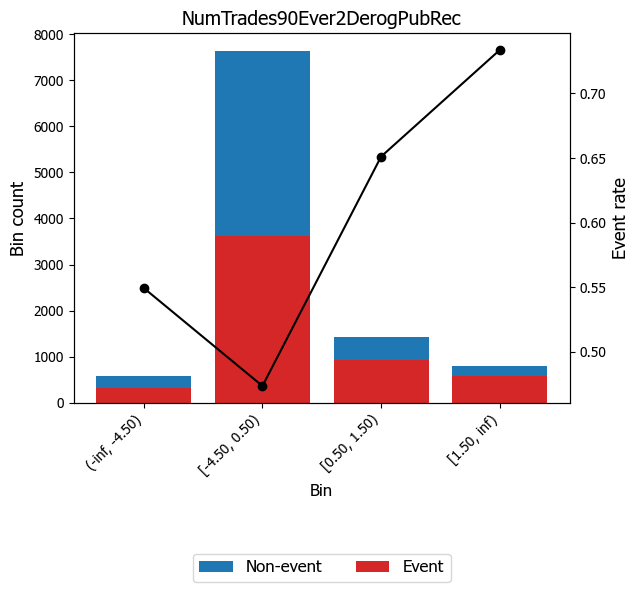

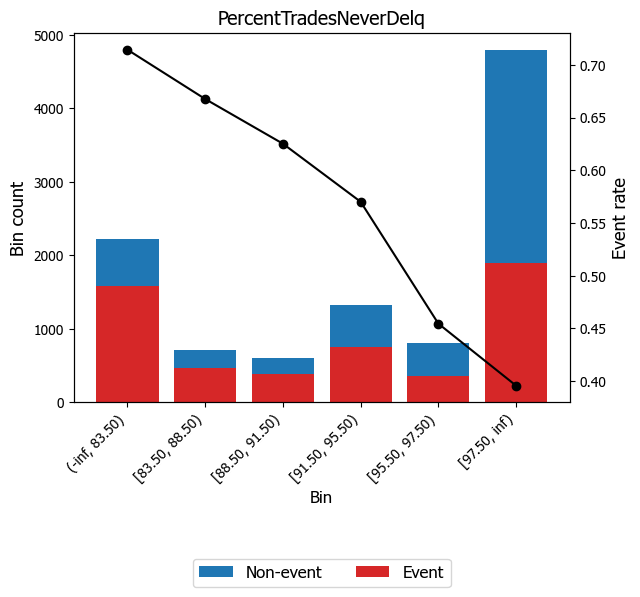

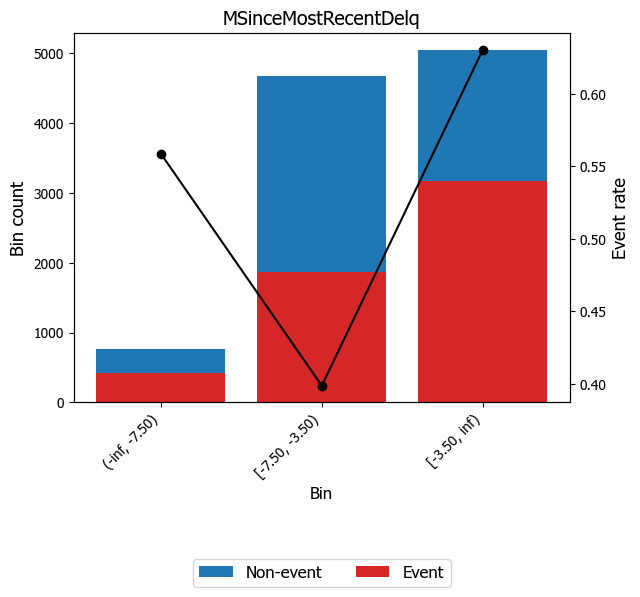

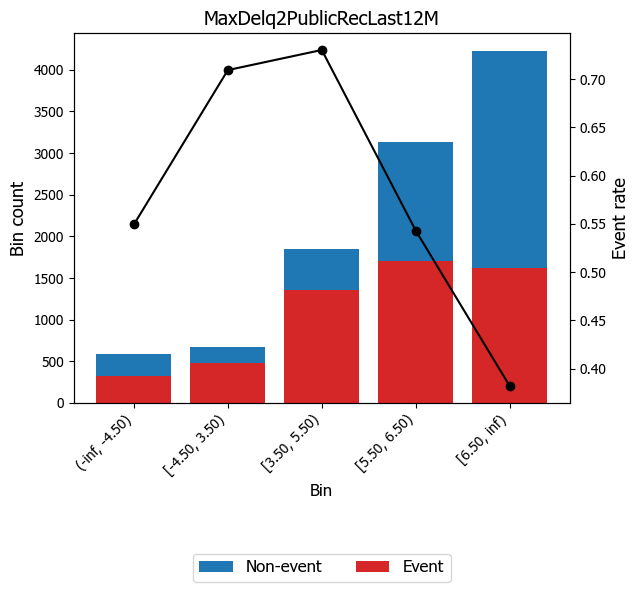

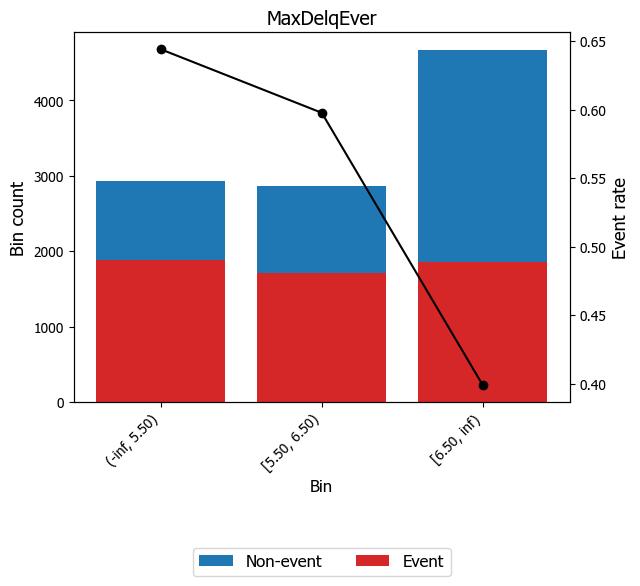

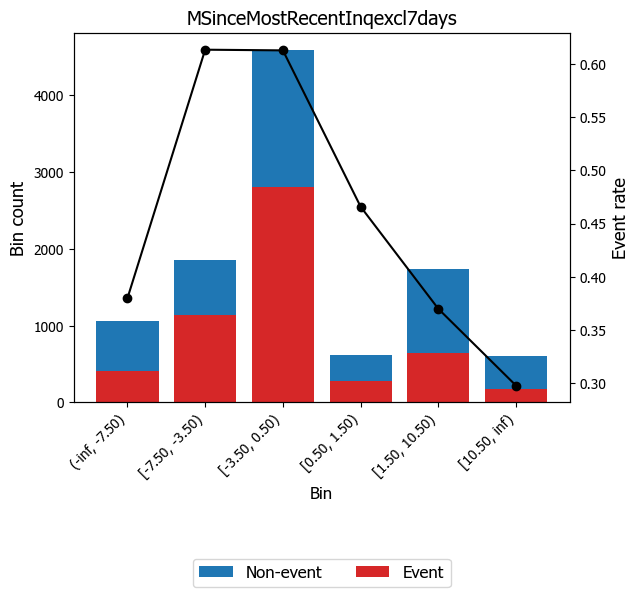

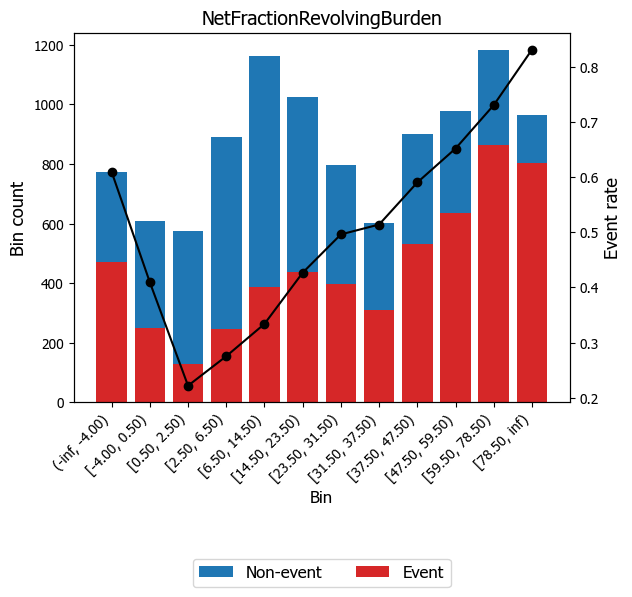

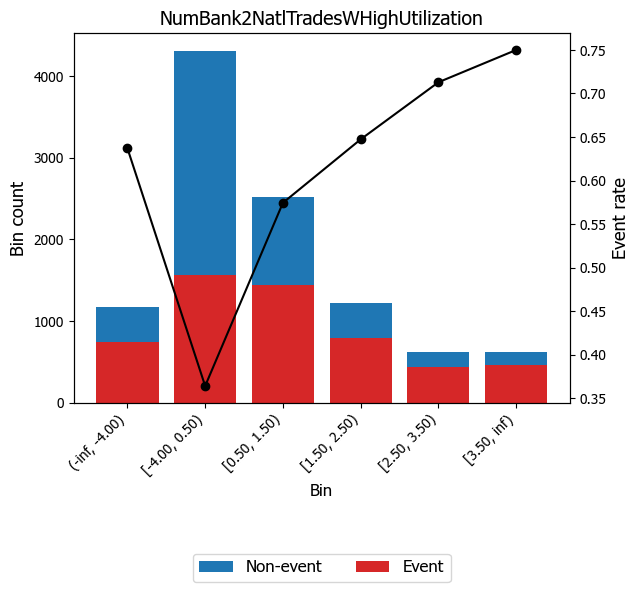

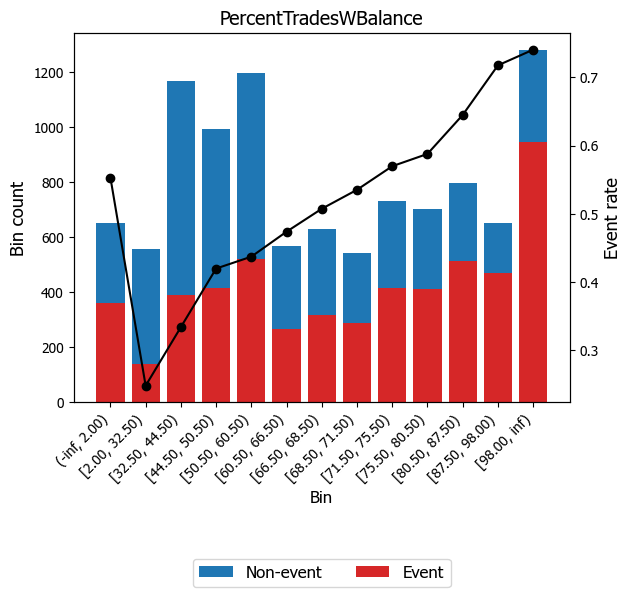

In [10]:
# Details of factor
factors = binning_process.get_support(names = True)
WOESummary = [] 
for factor in factors:
    build = binning_process.get_binned_variable(factor)
    woe_table = build.binning_table.build()
    woe_table['Factor'] = factor
    woe_table = woe_table.drop(woe_table.tail(1).index)
    WOESummary.append(woe_table)
    #plot
    plt.rcParams["font.family"] = "tahoma"
    build.binning_table.plot(metric='event_rate',add_special=False, add_missing=False, style='bin',show_bin_labels=True)
WOESummary = pd.concat(WOESummary)

# Reorder columns
cols = WOESummary.columns
cols = cols[-1:].append(cols[:-1])
WOESummary = WOESummary[cols]

In [11]:
WOESummary

,Factor,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,ExternalRiskEstimate,"(-inf, 63.50)",2776,0.265417,661,2115,0.761888,-1.075229,0.274434,3.274180e-02
1,ExternalRiskEstimate,"[63.50, 65.50)",681,0.065111,190,491,0.720999,-0.861592,0.044754,5.427377e-03
2,ExternalRiskEstimate,"[65.50, 67.50)",652,0.062339,195,457,0.700920,-0.763856,0.034156,4.168614e-03
3,ExternalRiskEstimate,"[67.50, 70.50)",1038,0.099245,388,650,0.626204,-0.428139,0.017755,2.202540e-03
4,ExternalRiskEstimate,"[70.50, 72.50)",642,0.061383,308,334,0.520249,0.006787,0.000003,3.534344e-07
...,...,...,...,...,...,...,...,...,...,...
10,PercentTradesWBalance,"[80.50, 87.50)",797,0.076202,283,514,0.644918,-0.508949,0.019114,2.363830e-03
11,PercentTradesWBalance,"[87.50, 98.00)",652,0.062339,184,468,0.717791,-0.845705,0.041380,5.023705e-03
12,PercentTradesWBalance,"[98.00, inf)",1277,0.122096,331,946,0.740799,-0.962296,0.103054,1.240666e-02
13,PercentTradesWBalance,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


In [12]:
WOESummary[WOESummary['Factor']=='ExternalRiskEstimate']

,Factor,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,ExternalRiskEstimate,"(-inf, 63.50)",2776,0.265417,661,2115,0.761888,-1.075229,0.274434,3.274180e-02
1,ExternalRiskEstimate,"[63.50, 65.50)",681,0.065111,190,491,0.720999,-0.861592,0.044754,5.427377e-03
2,ExternalRiskEstimate,"[65.50, 67.50)",652,0.062339,195,457,0.700920,-0.763856,0.034156,4.168614e-03
3,ExternalRiskEstimate,"[67.50, 70.50)",1038,0.099245,388,650,0.626204,-0.428139,0.017755,2.202540e-03
4,ExternalRiskEstimate,"[70.50, 72.50)",642,0.061383,308,334,0.520249,0.006787,0.000003,3.534344e-07
5,ExternalRiskEstimate,"[72.50, 74.50)",645,0.061669,319,326,0.505426,0.066121,0.000270,3.373317e-05
6,ExternalRiskEstimate,"[74.50, 76.50)",591,0.056506,349,242,0.409475,0.453962,0.011562,1.432991e-03
7,ExternalRiskEstimate,"[76.50, 78.50)",535,0.051152,335,200,0.373832,0.603641,0.018329,2.256900e-03
8,ExternalRiskEstimate,"[78.50, 81.50)",844,0.080696,590,254,0.300948,0.930616,0.066512,8.026449e-03
9,ExternalRiskEstimate,"[81.50, 84.50)",772,0.073812,590,182,0.235751,1.263944,0.107006,1.255097e-02


## SKlearn Logistic Regression

In [13]:
kwds = dict(max_iter=1000, class_weight="balanced"
            ,random_state=0, solver= "liblinear")
estimator = LogisticRegression(**kwds)

Finally, we instantiate a `Scorecard` class with the target name, a binning process object, and an estimator. In addition, we want to apply a scaling method to the scorecard points.

In [14]:
# scorecard = Scorecard(binning_process=binning_process,
#                       estimator=estimator, scaling_method="min_max",
#                       scaling_method_params={"min": 0, "max": 100})

# scorecard = Scorecard(binning_process=binning_process,
#                       estimator=estimator, scaling_method="pdo_odds",
#                       scaling_method_params={'pdo':20,'odds':50,'scorecard_points':600})
scorecard = Scorecard(binning_process=binning_process,estimator=estimator, scaling_method=None) # do not scaling

In [15]:
scorecard.fit(X, y)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.1}},
                                         variable_names=['ExternalRiskEstimate',
                                                         'MSinceOldestTradeOpen',
                                                         'MSinceMostRecentTradeOpen',
                                                         'AverageMInFile',
                                                         'NumSatisfactoryTrades',
                                                         'NumTrades60Ever2DerogPubRec',
                                                         'NumTrades90Ever2DerogPubRec',
                                                         'PercentTradesNeverDelq',
                                                         'MSinceMostRecentDelq',
                                                         'MaxDelq2PublicRecLast1...
                                                         'PercentInstallTrades',
                                                         'MSinceMostRecentInqexcl7days',
                                                         'NumInqLast6M',
                                                         'NumInqLast6Mexcl7days',
                                                         'NetFractionRevolvingBurden',
                                                         'NetFractionInstallBurden',
                                                         'NumRevolvingTradesWBalance',
                                                         'NumInstallTradesWBalance',
                                                         'NumBank2NatlTradesWHighUtilization',
                                                         'PercentTradesWBalance']),
          estimator=LogisticRegression(class_weight='balanced', max_iter=1000,
                                       random_state=0, solver='liblinear'))

In [16]:
pred = scorecard.predict(X)
pred_score = scorecard.predict_proba(X)[:, 1]
print(classification_report(y, pred))
print(confusion_matrix(y, pred))
print('Accuracy : ' + str(accuracy_score(y, pred)*100))
print('F1 score : ' + str(f1_score(y, pred)*100))

              precision    recall  f1-score   support

           0       0.72      0.69      0.71      5000
           1       0.73      0.75      0.74      5459

    accuracy                           0.72     10459
   macro avg       0.72      0.72      0.72     10459
weighted avg       0.72      0.72      0.72     10459

[[3469 1531]
 [1350 4109]]
Accuracy : 72.45434553972655
F1 score : 74.04270655013964


In [17]:
scorecard.information()

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                  10459
    Number of variables                   23
    Target type                       binary

    Number of numerical                   23
    Number of categorical                  0
    Number of selected                    13

  Timing
    Total time                          1.34 sec
    Binning process                     1.30 sec   ( 96.98%)
    Estimator                           0.02 sec   (  1.35%)
    Build scorecard                     0.02 sec   (  1.62%)
      rounding                          0.00 sec   (  0.00%)



In [18]:
print('coefficient:', scorecard.estimator_.coef_)
print('intercept:', scorecard.estimator_.intercept_)

coefficient: [[-0.33855834 -0.22212888 -0.63716764 -0.51428797  0.14963197 -0.59793792
  -1.7242787  -0.44644035  2.39701581 -0.88661213 -0.39927139 -0.1942324
  -0.20393461]]
intercept: [-0.02273246]


In [19]:
scorecard.table(style="summary")[scorecard.table(style="summary")["Variable"]=="ExternalRiskEstimate"]

,Variable,Bin,Points
0,ExternalRiskEstimate,"(-inf, 63.50)",0.364028
1,ExternalRiskEstimate,"[63.50, 65.50)",0.291699
2,ExternalRiskEstimate,"[65.50, 67.50)",0.258610
3,ExternalRiskEstimate,"[67.50, 70.50)",0.144950
4,ExternalRiskEstimate,"[70.50, 72.50)",-0.002298
5,ExternalRiskEstimate,"[72.50, 74.50)",-0.022386
6,ExternalRiskEstimate,"[74.50, 76.50)",-0.153693
7,ExternalRiskEstimate,"[76.50, 78.50)",-0.204368
8,ExternalRiskEstimate,"[78.50, 81.50)",-0.315068
9,ExternalRiskEstimate,"[81.50, 84.50)",-0.427919


In [20]:
score_table = scorecard.table(style="detailed")
score_table

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,ExternalRiskEstimate,0,"(-inf, 63.50)",2776,0.265417,661,2115,0.761888,-1.075229,0.274434,3.274180e-02,-0.338558,0.364028
1,ExternalRiskEstimate,1,"[63.50, 65.50)",681,0.065111,190,491,0.720999,-0.861592,0.044754,5.427377e-03,-0.338558,0.291699
2,ExternalRiskEstimate,2,"[65.50, 67.50)",652,0.062339,195,457,0.700920,-0.763856,0.034156,4.168614e-03,-0.338558,0.258610
3,ExternalRiskEstimate,3,"[67.50, 70.50)",1038,0.099245,388,650,0.626204,-0.428139,0.017755,2.202540e-03,-0.338558,0.144950
4,ExternalRiskEstimate,4,"[70.50, 72.50)",642,0.061383,308,334,0.520249,0.006787,0.000003,3.534344e-07,-0.338558,-0.002298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,PercentTradesWBalance,10,"[80.50, 87.50)",797,0.076202,283,514,0.644918,-0.508949,0.019114,2.363830e-03,-0.203935,0.103792
11,PercentTradesWBalance,11,"[87.50, 98.00)",652,0.062339,184,468,0.717791,-0.845705,0.041380,5.023705e-03,-0.203935,0.172468
12,PercentTradesWBalance,12,"[98.00, inf)",1277,0.122096,331,946,0.740799,-0.962296,0.103054,1.240666e-02,-0.203935,0.196246
13,PercentTradesWBalance,13,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000e+00,-0.203935,-0.000000


In [21]:
score_table[score_table['Variable']=='ExternalRiskEstimate']

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,ExternalRiskEstimate,0,"(-inf, 63.50)",2776,0.265417,661,2115,0.761888,-1.075229,0.274434,3.274180e-02,-0.338558,0.364028
1,ExternalRiskEstimate,1,"[63.50, 65.50)",681,0.065111,190,491,0.720999,-0.861592,0.044754,5.427377e-03,-0.338558,0.291699
2,ExternalRiskEstimate,2,"[65.50, 67.50)",652,0.062339,195,457,0.700920,-0.763856,0.034156,4.168614e-03,-0.338558,0.258610
3,ExternalRiskEstimate,3,"[67.50, 70.50)",1038,0.099245,388,650,0.626204,-0.428139,0.017755,2.202540e-03,-0.338558,0.144950
4,ExternalRiskEstimate,4,"[70.50, 72.50)",642,0.061383,308,334,0.520249,0.006787,0.000003,3.534344e-07,-0.338558,-0.002298
5,ExternalRiskEstimate,5,"[72.50, 74.50)",645,0.061669,319,326,0.505426,0.066121,0.000270,3.373317e-05,-0.338558,-0.022386
6,ExternalRiskEstimate,6,"[74.50, 76.50)",591,0.056506,349,242,0.409475,0.453962,0.011562,1.432991e-03,-0.338558,-0.153693
7,ExternalRiskEstimate,7,"[76.50, 78.50)",535,0.051152,335,200,0.373832,0.603641,0.018329,2.256900e-03,-0.338558,-0.204368
8,ExternalRiskEstimate,8,"[78.50, 81.50)",844,0.080696,590,254,0.300948,0.930616,0.066512,8.026449e-03,-0.338558,-0.315068
9,ExternalRiskEstimate,9,"[81.50, 84.50)",772,0.073812,590,182,0.235751,1.263944,0.107006,1.255097e-02,-0.338558,-0.427919


In [22]:
## recheck point output if do not scaling
from sklearn.preprocessing import minmax_scale
score_table["WoE"] * score_table["Coefficient"]

0     0.364028
1     0.291699
2     0.258610
3     0.144950
4    -0.002298
        ...   
10    0.103792
11    0.172468
12    0.196246
13   -0.000000
14   -0.000000
Length: 121, dtype: float64

## Scorecard performance
Compute predicted probabilities of the fitted estimator.

In [23]:
y_pred = scorecard.predict_proba(X)[:, 1]

Plot Area Under the Receiver Operating Characteristic Curve (AUC ROC).

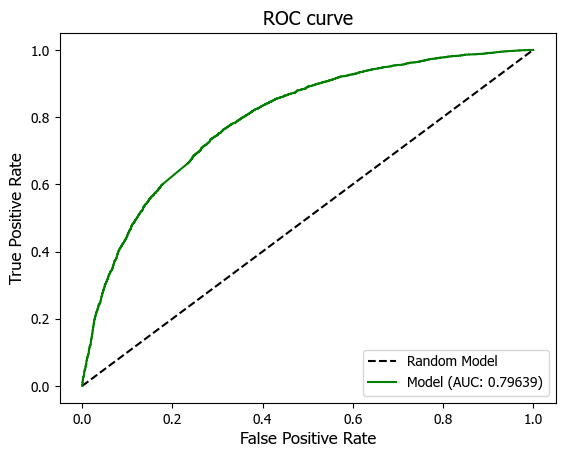

In [24]:
plot_auc_roc(y, y_pred)

Plot Cumulative Accuracy Profile (CAP).

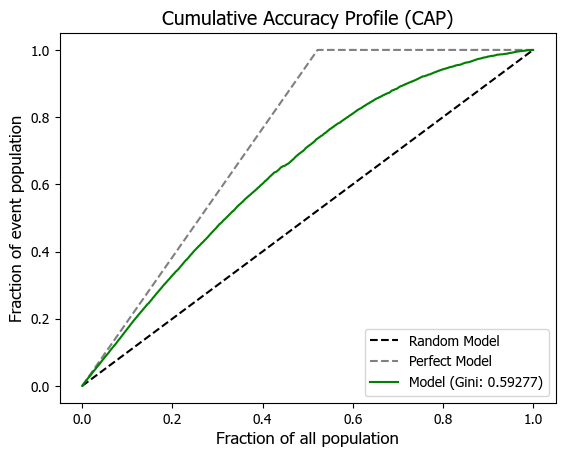

In [25]:
plot_cap(y, y_pred)

Plot Kolmogorov-Smirnov (KS).

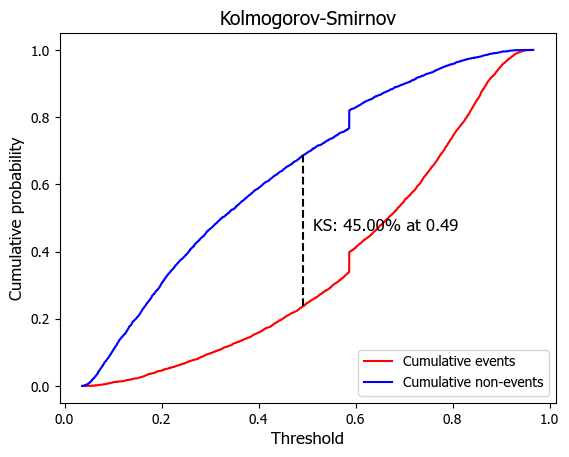

In [26]:
plot_ks(y, y_pred)

Calculate the score of the dataset and plot distribution of scores for event and non-event records.

In [27]:
score = scorecard.score(X)

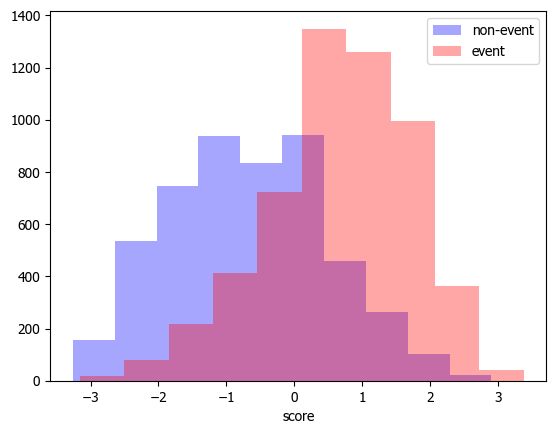

In [28]:
mask = y == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

In [29]:
output_df = pd.DataFrame()
X_t = scorecard._transform(X, metric="indices", metric_special="empirical",metric_missing="empirical")
selected_variables = scorecard.binning_process_.get_support(names=True)
for variable in selected_variables:
    mask = scorecard._df_scorecard.Variable == variable
    points = scorecard._df_scorecard[mask].Points.values
    points = points[X_t[variable]]
    output_df[variable] = points
output_df['score'] = score 
output_df['label'] = y

In [30]:
output_df.head()

,ExternalRiskEstimate,MSinceOldestTradeOpen,AverageMInFile,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,MSinceMostRecentInqexcl7days,NetFractionRevolvingBurden,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,score,label
0,0.364028,0.025401,-0.222662,0.453943,0.029023,0.495558,0.769883,0.358674,-1.210393,0.329295,-0.012473,0.041164,0.010732,1.432172,1
1,0.364028,0.139229,0.491034,0.453943,-0.138482,-0.305597,-0.859205,0.358674,1.194429,0.329295,-0.181148,0.092223,0.025482,1.963905,1
2,0.258610,0.139229,0.491034,-0.143760,0.029023,-0.305597,-0.859205,-0.253745,1.194429,0.329295,0.215605,0.041164,0.103792,1.239874,1
3,0.258610,0.002989,-0.027438,0.239274,-0.080220,0.116345,0.769883,0.037790,-0.737725,0.329295,0.363551,0.159600,0.172468,1.604425,1
4,-0.315068,-0.109145,-0.448194,-0.143760,0.029023,-0.305597,-0.859205,-0.253745,1.194429,0.329295,0.215605,-0.125471,0.054403,-0.737430,1


## Score binning

In [31]:
import seaborn as sns
def score_bins_plot(
        dataframe:pd.DataFrame,
        bins,score_col='score',
        label_col='label',
        title='binned score histogram',
        show=True
    ):
    bin_cut = pd.cut(dataframe[score_col],bins, include_lowest = True, right = False, precision = 0, retbins = False)
    dataframe['bins'] = bin_cut
    df_binned = dataframe.groupby('bins').agg({label_col: 'sum', score_col: 'count'}).reset_index().rename(columns={label_col:'event',score_col:'all'})
    df_binned['non-event'] = df_binned['all'] - df_binned['event']
    df_binned['%event'] = (df_binned['event'] / df_binned['all'])*100
    df_binned['index'] = df_binned.index
    fig, ax1 = plt.subplots(figsize=(10, 6))
    # Bar plot (stacked)
    sns.barplot(x=df_binned['bins'].astype(str), y=df_binned['event'], color='r', alpha = 0.5, label='Event', ax=ax1)
    sns.barplot(x=df_binned['bins'].astype(str), y=df_binned['non-event'], color='g',alpha = 0.5, label='Non-event', ax=ax1, bottom=df_binned['event'])
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Bins')
    # Line plot (%event)
    ax2 = ax1.twinx()
    sns.lineplot(x=df_binned['bins'].astype(str), y=df_binned['%event'], color='k', marker='o', ax=ax2)
    ax2.set_ylabel('% Event')
    for i, (_, pct_event) in enumerate(zip(df_binned['bins'].astype(str), df_binned['%event'])):
        ax2.text(i, pct_event + 2, f'{pct_event:.2f}%', color='k', ha='center', rotation=90)
    # Add legends
    ax1.legend(loc='upper left', title='Counts')
    ax2.legend(['% Event'], loc='upper right', title='Percentage')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    plt.title(title)
    if show == False:
        plt.close()
    return fig,ax1,df_binned

def interval_binning(manual_bins):
    if type(manual_bins) == int:
        _, bin_edges = pd.cut(score,manual_bins, retbins=True)
        bin_edges[0] = -np.inf
        bin_edges[-1] = np.inf
        manual_bins = bin_edges
    interval_bins = pd.IntervalIndex.from_breaks(manual_bins, closed='left')
    rounded_intervals = pd.IntervalIndex([
        pd.Interval(round(interval.left, 2), round(interval.right, 2), closed='left') 
        for interval in interval_bins
    ])
    return rounded_intervals

In [32]:
rounded_intervals = interval_binning(20)

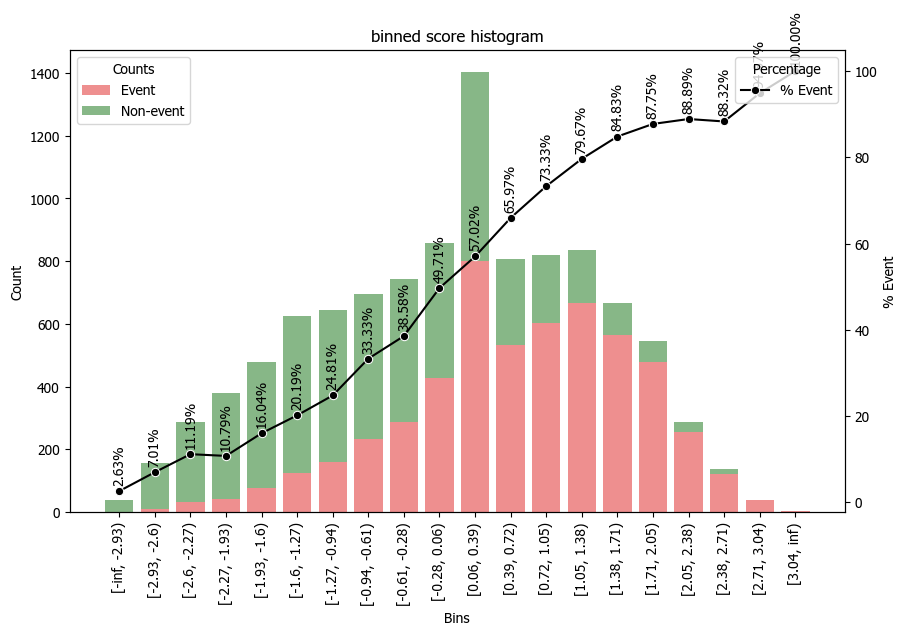

In [33]:
fig_score,ax,df_bins = score_bins_plot(output_df,rounded_intervals,score_col='score',label_col='label',show=False)
fig_score

(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='Bins', ylabel='Count'>,
            bins  event   all  non-event     %event  index
 0  [-inf, -1.6)    162  1341       1179  12.080537      0
 1  [-1.6, 0.06)   1232  3568       2336  34.529148      1
 2  [0.06, 1.71)   3166  4534       1368  69.827966      2
 3   [1.71, inf)    899  1016        117  88.484252      3)

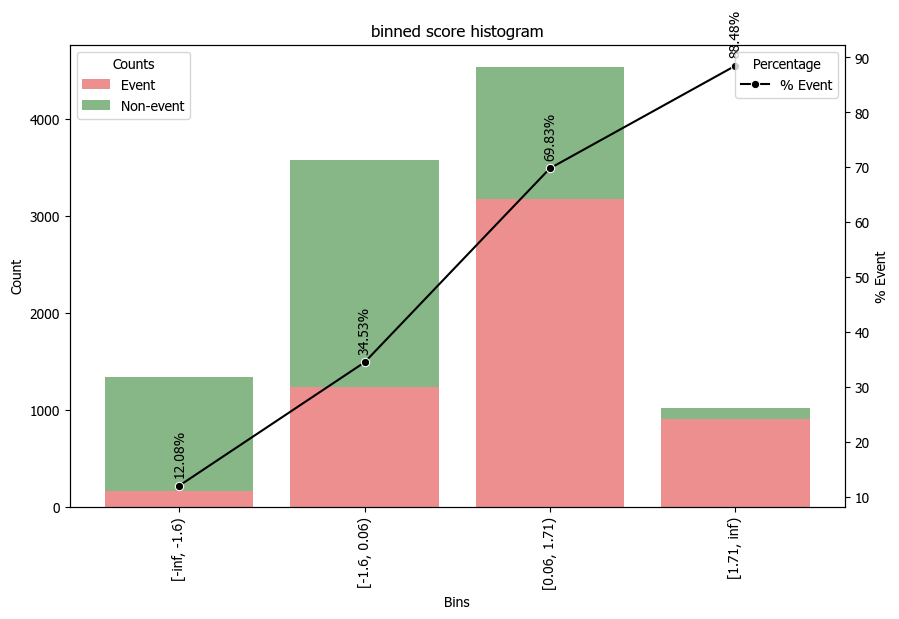

In [34]:
cutoff_interval = interval_binning(4)
score_bins_plot(output_df,cutoff_interval,score_col='score',label_col='label',show=True)